<a href="https://colab.research.google.com/github/amirahammadii/autism-detection/blob/model-fine-tuning-and-saving/autism_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20
3/3 [==============================] - 10s 878ms/step - loss: 1.1160 - accuracy: 0.3205 - val_loss: 1.0855 - val_accuracy: 0.4615
Epoch 2/20
3/3 [==============================] - 3s 861ms/step - loss: 1.1350 - accuracy: 0.2436 - val_loss: 1.0893 - val_accuracy: 0.3846
Epoch 3/20
3/3 [==============================] - 2s 462ms/step - loss: 1.0629 - accuracy: 0.4359 - val_loss: 1.1018 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 1s 472ms/step - loss: 1.0704 - accuracy: 0.4615 - val_loss: 1.0918 - val_accuracy: 0.3590
Epoch 5/20
3/3 [==============================] - 1s 443ms/step - loss: 1.0500 - accuracy: 0.4103 - val_loss: 1.0699 - val_accuracy: 0.4359
Epoch 6/20
3/3 [==============================] - 1s 438ms/step - loss: 1.0310 - accuracy: 0.5385 - val_loss: 1.0568 - val_accuracy: 0.4359
Epoch 7/20
3/3 [==============================] - 1s 462ms/step - loss: 1.0505 - accuracy: 0.4103 - val_loss: 1.0483 - val_accuracy: 0.4359
Epoch 8/20
3/3 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 - 1s - loss: 0.4263 - accuracy: 0.8462 - 710ms/epoch - 355ms/step
Loaded Model Score: 0.4262795150279999
Loaded Model Accuracy: 0.8461538553237915


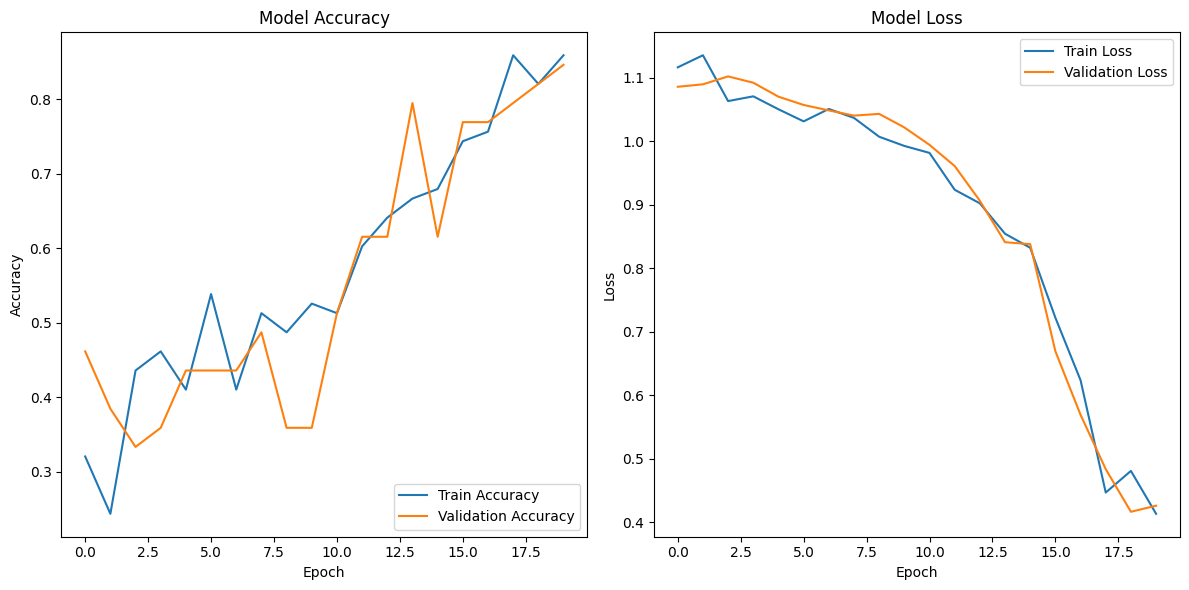

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample

# Load and inspect data
data = pd.read_excel('/content/Dataset for Autism Diagnosis.xlsx')

# Data Cleaning and Preparation
def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', str(text).lower())
    return text

data['processed_text'] = data['Please can you give us some of your child’s unique behaviors that prompted you to go for a diagnosis'].apply(clean_text)

def convert_label(label):
    if label == 'Level 1 (Mild Autism)':
        return 0
    elif label == 'Level 2 (Moderate Autism)':
        return 1
    elif label == 'Level 3 (Severe Autism)':
        return 2
    else:
        return -1

data['labels'] = data['If Diagnosis is yes , what was his/her diagnosis? (DSM 5 Diagnosis)'].apply(convert_label)
data = data[data['labels'] != -1]

# Select and preprocess other features
data['Age_group'] = LabelEncoder().fit_transform(data['Which age group does your child belong to'].astype(str))
data['Sex'] = LabelEncoder().fit_transform(data['Sex of child'].astype(str))
data['Disability_type'] = LabelEncoder().fit_transform(data['Which type of disability do he/she have'].astype(str))

other_features = data[['Age_group', 'Sex', 'Disability_type']]

# Standardize other features
scaler = StandardScaler()
other_features_scaled = scaler.fit_transform(other_features)

# Verify Data Distribution and Balance the Dataset
class_0 = data[data['labels'] == 0]
class_1 = data[data['labels'] == 1]
class_2 = data[data['labels'] == 2]

max_size = max(len(class_0), len(class_1), len(class_2))

class_0_resampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_resampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)
class_2_resampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

data_balanced = pd.concat([class_0_resampled, class_1_resampled, class_2_resampled])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Tokenization and Sequencing for LSTM
tokenizer_lstm = Tokenizer(num_words=2000, split=' ')
tokenizer_lstm.fit_on_texts(data_balanced['processed_text'].values)
X_text = tokenizer_lstm.texts_to_sequences(data_balanced['processed_text'].values)
X_text = pad_sequences(X_text, maxlen=50)

# Extract other features from the balanced data
other_features_balanced = data_balanced[['Age_group', 'Sex', 'Disability_type']]
other_features_scaled_balanced = scaler.transform(other_features_balanced)

# Combine text and other features
X_combined_text = X_text
X_combined_other = other_features_scaled_balanced

Y = pd.get_dummies(data_balanced['labels']).values
X_train_text, X_test_text, X_train_other, X_test_other, Y_train, Y_test = train_test_split(X_combined_text, X_combined_other, Y, test_size=0.33, random_state=42)

# Build and Train LSTM Model
text_input = Input(shape=(50,), name='text_input')
embedding = Embedding(input_dim=2000, output_dim=128, input_length=50)(text_input)
spatial_dropout = SpatialDropout1D(0.3)(embedding)
lstm1 = LSTM(196, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(spatial_dropout)
lstm2 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(lstm1)

other_input = Input(shape=(X_combined_other.shape[1],), name='other_input')
dense_other = Dense(32, activation='relu')(other_input)

combined = concatenate([lstm2, dense_other])
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=[text_input, other_input], outputs=[output])

optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_train_text, X_train_other], Y_train, epochs=20, batch_size=32, validation_data=([X_test_text, X_test_other], Y_test), callbacks=[early_stopping])

# Evaluate the LSTM Model
score, acc = model.evaluate([X_test_text, X_test_other], Y_test, verbose=2)
print(f"Model Score: {score}")
print(f"Model Accuracy: {acc}")

# Save the model
model.save('autism_lstm_model.h5')

# Load the saved model
model_lstm_loaded = load_model('autism_lstm_model.h5')

# Evaluate the loaded model
score_loaded, acc_loaded = model_lstm_loaded.evaluate([X_test_text, X_test_other], Y_test, verbose=2)
print(f"Loaded Model Score: {score_loaded}")
print(f"Loaded Model Accuracy: {acc_loaded}")

# Plot Training History
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
